In [142]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from pandas.tseries.offsets import DateOffset
from pandas.plotting import autocorrelation_plot
import pandas.util.testing as tm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from numpy import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [143]:
# Leitura do CSV e setando como Time
df = pd.read_csv('FT01_18_19.csv',delimiter=';', parse_dates=True)
df['Time'] = pd.to_datetime(df.Time)
df = df[df['Time'].notna()]
df = df.set_index('Time')
df = df.resample("D").last()

In [144]:
#Separar dados de treino e teste
dias = 30
train = df.iloc[:-dias,0:1].copy()
test = df.iloc[-dias:,0:1].copy()

history = [train.iloc[i,0] for i in range(len(train))]
predictions = []

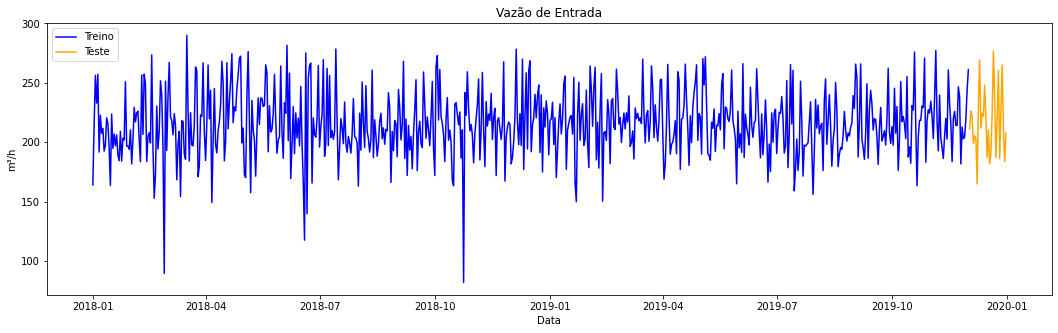

In [145]:
# Visualização das amostras de treino e teste
plt.figure(figsize=(18,5))
plt.title('Vazão de Entrada')
plt.plot(train['Vazao01'], color='b')
plt.plot(test['Vazao01'], color='orange')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('m³/h')
plt.show()

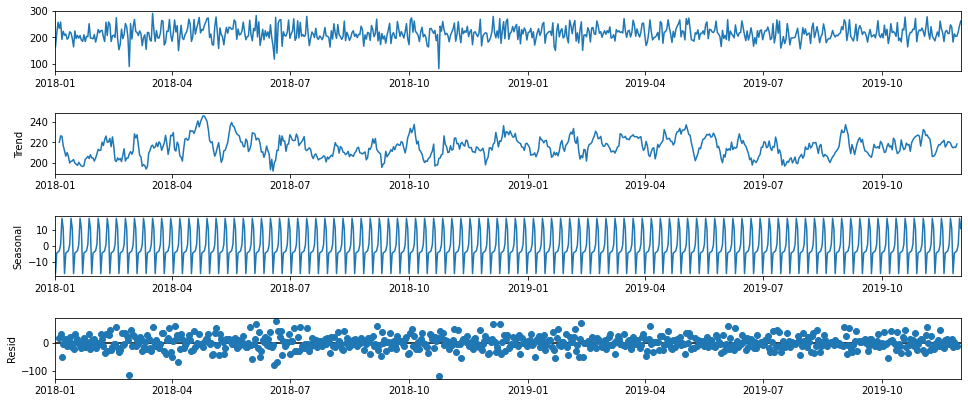

In [146]:
#Verificando Residuais, Sazonalidade e Tendencias
result = seasonal_decompose(train)
fig = result.plot()
fig.set_size_inches(15,6)

In [147]:
#Verificando atraves de Dickey Fuller a estacionariedade
X = df.values
result = adfuller(X)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(-5.327224857999853, 4.807658320971117e-06, 20, 709, {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}, 6695.738442298982)
ADF Statistic: -5.327225
p-value: 0.000005
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


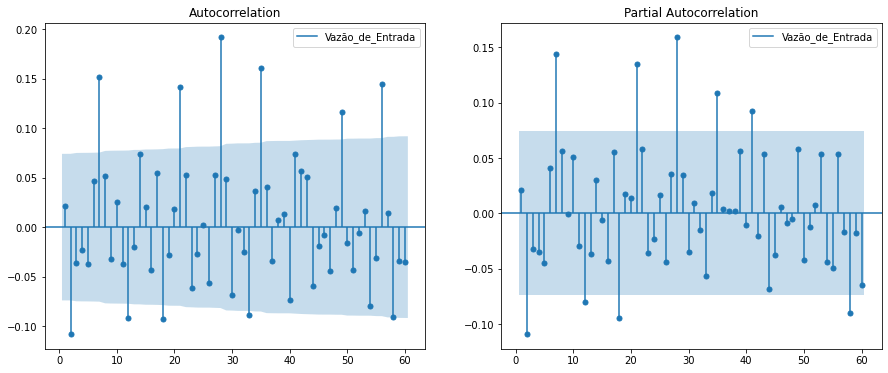

In [148]:
# Análise de auto correlação dos lags anteriores
fig, ax = plt.subplots(1,2,figsize=(15,6))
plot_acf(train['Vazao01'], lags=60, zero=False, ax=ax[0]);
plot_pacf(train['Vazao01'], lags=60, zero=False, ax=ax[1]);
ax[0].legend(["Vazão_de_Entrada"], loc="upper right")
ax[1].legend(["Vazão_de_Entrada"], loc="upper right")
plt.show()

In [149]:
#Rodar o ARIMA para os dados de treino, fazer forecast para o tamanho dos dados test
for t in range(len(test)):
    #model = ARIMA(history, order=(1,1,0))
    model = sm.tsa.statespace.SARIMAX(history, order=(1,1,0), seasonal_order=(1,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t,0]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
test['Predict'] = predictions

predicted=244.867494, expected=211.010000
predicted=234.205593, expected=226.500000
predicted=220.182854, expected=221.290000
predicted=223.157896, expected=199.020000
predicted=211.294229, expected=205.350000
predicted=207.071727, expected=203.500000
predicted=208.395381, expected=164.880000
predicted=175.865319, expected=233.180000
predicted=201.749870, expected=269.250000
predicted=253.576207, expected=211.860000
predicted=233.774336, expected=224.300000
predicted=218.309207, expected=221.930000
predicted=223.110408, expected=248.120000
predicted=230.977745, expected=220.410000
predicted=239.925034, expected=187.090000
predicted=210.937553, expected=210.400000
predicted=194.383283, expected=181.750000
predicted=192.593663, expected=190.850000
predicted=187.271014, expected=224.100000
predicted=212.948960, expected=276.710000
predicted=251.343319, expected=236.760000
predicted=247.886909, expected=187.130000
predicted=210.105239, expected=221.300000
predicted=203.667698, expected=260

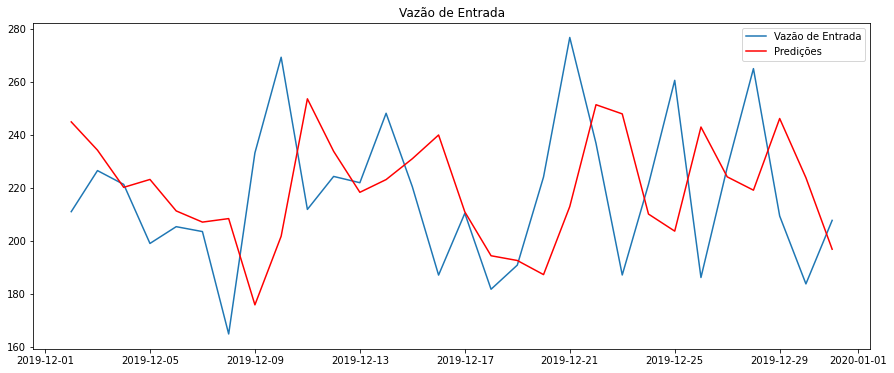

In [150]:
# Plotar a previsão e comparar com os testes
plt.figure(figsize=(15,6))
plt.plot(test['Vazao01'])
plt.plot(test['Predict'], color='red')
plt.title('Vazão de Entrada')
plt.legend(['Vazão de Entrada', 'Predições'], loc="upper right")
plt.show()

In [151]:
# -----------------------------Função para analisar erros--------------------------------
def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = mean_absolute_percentage_error(orig, prev)
    
    grupo_erro = [mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie
    
def plotar_erro(dados, figsize=(15,6)):
    
    # Criando a coluna do erro
    dados['Erro'] = dados.iloc[:,0] - dados.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotando os valores reais e previstos
    ax1.plot(dados.iloc[:,0:2])
    ax1.legend(['Real','Prev'])
    ax1.set_title('Valores Reais vs Previstos')
    
    # Erro vs Valores previstos
    ax2.scatter(dados.iloc[:,1], dados.iloc[:,2])
    ax2.set_xlabel('Valores Previstos')
    ax2.set_ylabel('Resíduo')
    ax2.set_title('Resíduo vs Valores Previstos')
    
    ## QQ Plot do erro
    ax3.set_title('Gráfico QQ')
    sm.graphics.qqplot(dados.iloc[:,2], line='r', ax=ax3)
    
    # Gráfico de autocorrelação do Erro
    plot_acf(dados.iloc[:,2], lags=29, zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

MODELO ARIMA PARA O TREINO COMPARADO NA BASE DE TESTE


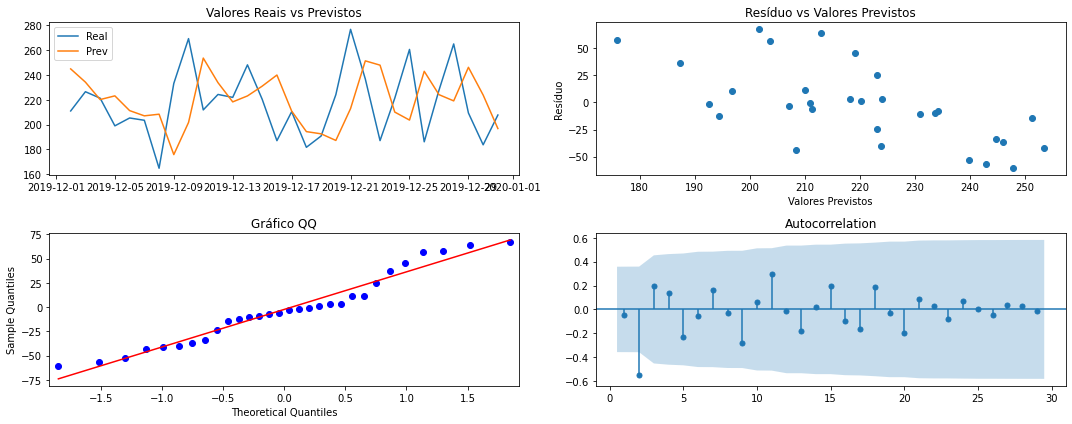

,Erros
Base Treino,
MSE,1273.410387
RMSE,35.684876
MAE,28.020188
MAPE,0.129488


In [152]:
erro_teste = check_erro(test['Vazao01'], test['Predict'], nome_col='Erros',nome_indice='Base Treino')
print('MODELO ARIMA PARA O TREINO COMPARADO NA BASE DE TESTE')

plotar_erro(test)
erro_teste

<AxesSubplot:>

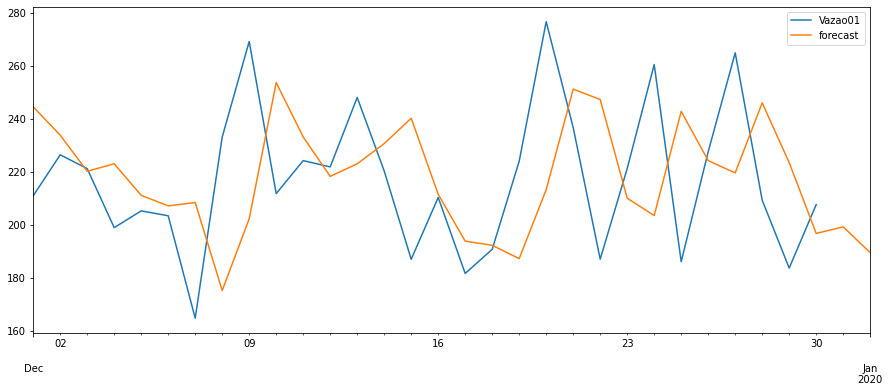

In [153]:
# Prevendo 1-step a frente

previsao = model_fit.predict(700,df['Vazao01'].count()+1,dynamic=False)

future_dates = [test.index[-1] + DateOffset(days = x)for x in range(0,3)]
future_datest_df = pd.DataFrame(index = future_dates[1:], columns = test.columns)
future_datest_df.tail()

future_df = pd.concat([test,future_datest_df])
future_df.index = pd.date_range(start='2019-12-01', end='2020-01-01')
future_df['forecast'] = previsao
future_df[['Vazao01', 'forecast']].plot(figsize=(15, 6))

<AxesSubplot:>

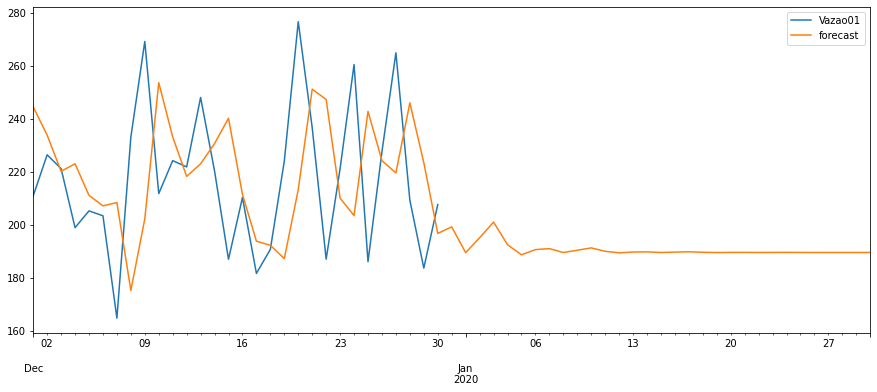

In [154]:
previsao = model_fit.predict(700,df['Vazao01'].count()+30,dynamic=False)

future_dates = [test.index[-1] + DateOffset(days = x)for x in range(0,32)]
future_datest_df = pd.DataFrame(index = future_dates[1:], columns = test.columns)
future_datest_df.tail()

future_df = pd.concat([test,future_datest_df])
future_df.index = pd.date_range(start='2019-12-01', end='2020-01-30')
future_df['forecast'] = previsao
future_df[['Vazao01', 'forecast']].plot(figsize=(15, 6))